In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
import pandas as pd

%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from keras.layers import BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers.legacy import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model
from sklearn.model_selection import train_test_split

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.13.0


In [2]:
data_path = "dataset/"
emotions = os.listdir(data_path)
print(emotions)

['lvha_angry', 'lvna_miserable', 'nvha_alarmed', '.DS_Store', 'hvna_happy', 'lvha_confused', 'nvha_tense', 'nvna_neutral', 'lvla_sad', 'lvha_annoyed-frustrated', 'lvha_afraid']


dataset/lvha_angry
dataset/lvna_miserable
dataset/nvha_alarmed
dataset/.DS_Store
dataset/hvna_happy
dataset/lvha_confused
dataset/nvha_tense
dataset/nvna_neutral
dataset/lvla_sad
dataset/lvha_annoyed-frustrated
dataset/lvha_afraid


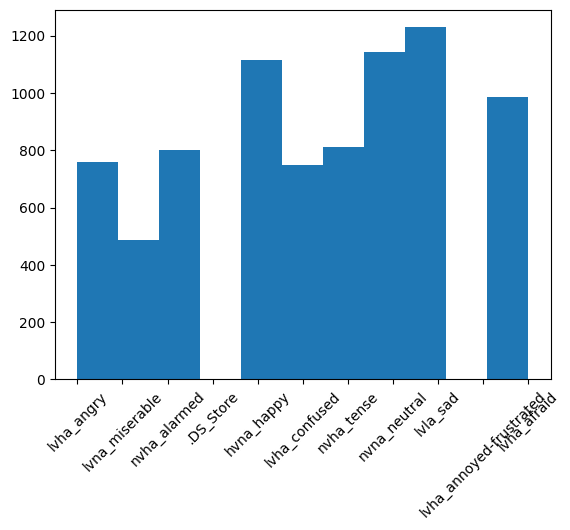

In [12]:
img_size = 48 #By default, the images in FER2013 dataset is in 48x48
batch_size = 64

data = []
labels = []

# Looping through subfolders in the data path
for emotion in emotions:
    emotion_folder = os.path.join(data_path, emotion)
    print(emotion_folder)
    if not os.path.isdir(emotion_folder):
        continue
    for img in os.listdir(emotion_folder):
        img_path = os.path.join(emotion_folder, img)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (img_size, img_size))
            data.append(img)
            labels.append(emotions.index(emotion))

# Convert image data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

# Plot the distribution of the labels, bar graph
plt.hist(labels, bins=len(emotions))
plt.xticks(range(len(emotions)), emotions, rotation=45)
plt.show()

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)

# Normalize the data
X_train = X_train / 255.0
X_val = X_val / 255.0

# Reshape the data to add a channel dimension
X_train = X_train.reshape(-1, img_size, img_size, 1)
X_val = X_val.reshape(-1, img_size, img_size, 1)


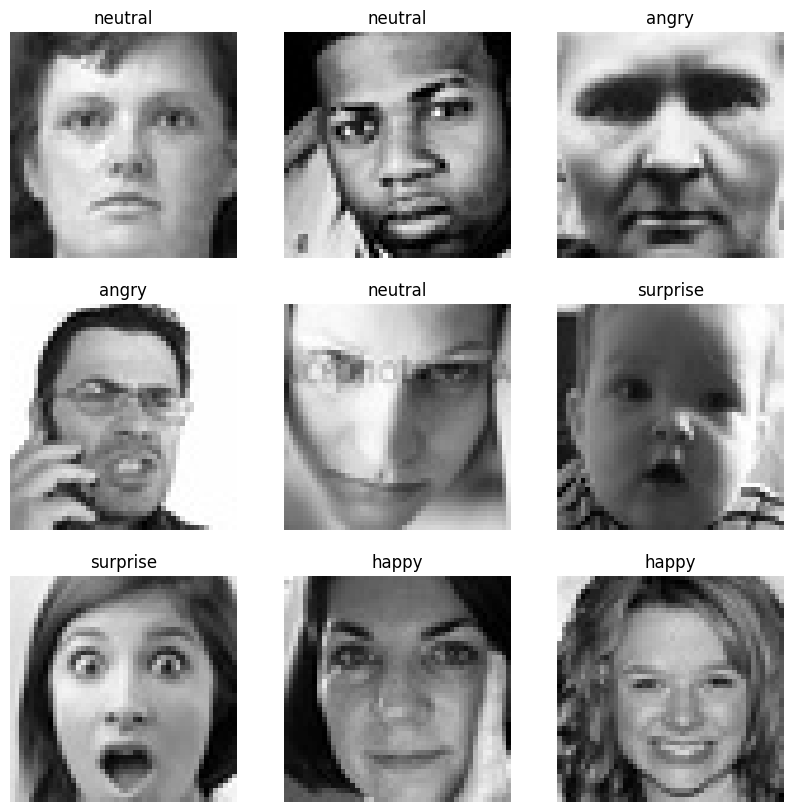

In [3]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i].reshape(img_size, img_size), cmap='gray')
    plt.title(emotions[y_train[i]])
    plt.axis('off')
plt.show()

In [4]:
def train_data_generator(img_size, batch_size):
    datagen_tr = ImageDataGenerator(horizontal_flip= True) #Randomly flips images along the horizontal axis
    train_gen = datagen_tr.flow_from_directory("train/",
                                              target_size=(img_size, img_size),
                                              color_mode='grayscale',
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)
    return train_gen

def test_data_generator(img_size, batch_size):
    datagen_ts = ImageDataGenerator(horizontal_flip= True) #Randomly flips images along the horizontal axis
    test_gen = datagen_ts.flow_from_directory("test/",
                                              target_size=(img_size, img_size),
                                              color_mode='grayscale',
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)
    return test_gen

In [5]:
model = Sequential()

#conv1
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 1))) # 48 = size, 1=grayscale (3 if rgb)
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # shrinks size to 2
model.add(Dropout(0.25))

# conv2

model.add(Conv2D(128, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # shrinks size to 2
model.add(Dropout(0.25))

#conv 3
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # shrinks size to 2
model.add(Dropout(0.25))

#conv 4
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2))) # shrinks size to 2
model.add(Dropout(0.25))

# flatten layers
model.add(Flatten())

# fully-connected layers
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

opt = Adam(lr=0.0005) #learning rate since it speeds up training, you can reduce to yor liking
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

/Users/riaacordero/miniconda3/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
train_gen = train_data_generator(img_size, batch_size)
test_gen = test_data_generator(img_size, batch_size)

epochs = 25
steps_per_epoch = train_gen.n//train_gen.batch_size
test_steps = test_gen.n//test_gen.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                            save_weights_only=True, mode='max', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001, model='auto')

callbacks= [PlotLossesKeras(), checkpoint, reduce_lr]

history = model.fit(x = train_gen,
                   steps_per_epoch = steps_per_epoch,
                   epochs=epochs,
                   validation_data=test_gen,
                   validation_steps = test_steps,
                   callbacks=callbacks
                   )

# ACCURACY can be improved with longer training and epoch steps

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)